# TO DO:

I) Belleza del código.

    1) Convertir listas en numpy array.
    
II) Preprocesamiento, ML, yerbas...

    1) (http://scikit-learn.org/stable/modules/preprocessing.html#scaling-data-with-outliers]Probar "robust_scale and RobustScaler" en vez de normalization de los datos
    2) Probar Grid_SearchCV en vez del "for"
    
III) Probar más hiperparametros

In [256]:
# Python 2 
from __future__ import division

# Preprocessing
from sklearn import preprocessing

# Dataframe
import pandas as pd
import numpy as np

# Time measurement
import datetime
from time import time

# Visu
import matplotlib.pyplot as plt

# The Hashing Trick
from sklearn.feature_extraction import FeatureHasher

# Dimension Reduction
from sklearn.decomposition import TruncatedSVD

# ML
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn import neighbors
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet

# Scoring
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

# Training Data Load

In [257]:
stations = pd.read_csv('data/station.csv')

trips = pd.read_csv('data/trip_train.csv', parse_dates=['start_date','end_date'], infer_datetime_format=True, low_memory=False)
more_trips = pd.read_csv('data/more_data/more_trips.csv', parse_dates=['start_date','end_date'], infer_datetime_format=True, low_memory=False)

weather = pd.read_csv('data/weather.csv', parse_dates=['date'], infer_datetime_format=True)
more_weather = pd.read_csv('data/more_data/more_weather.csv', parse_dates=['date'], infer_datetime_format=True)

In [258]:
#trips = trips.append(more_trips, ignore_index=True)

In [259]:
#weather = weather.append(more_weather, ignore_index=True)

In [260]:
trips['date'] = pd.to_datetime(trips.start_date.dt.date)

In [261]:
original_number_of_trips = trips['duration'].shape[0]

trip_length = 60*60*12     # seconds in 12 hours
trips_larger_than_12_hour = trips[trips['duration'] > trip_length]['duration'].sum()
trips_shorter_than_12_hour = trips[trips['duration'] < trip_length]['duration'].sum()
ratio = trips_larger_than_12_hour/trips_shorter_than_12_hour
print (trips_larger_than_12_hour,"/",trips_shorter_than_12_hour,'=',ratio)

118116828 / 494218194 = 0.23899732837435766


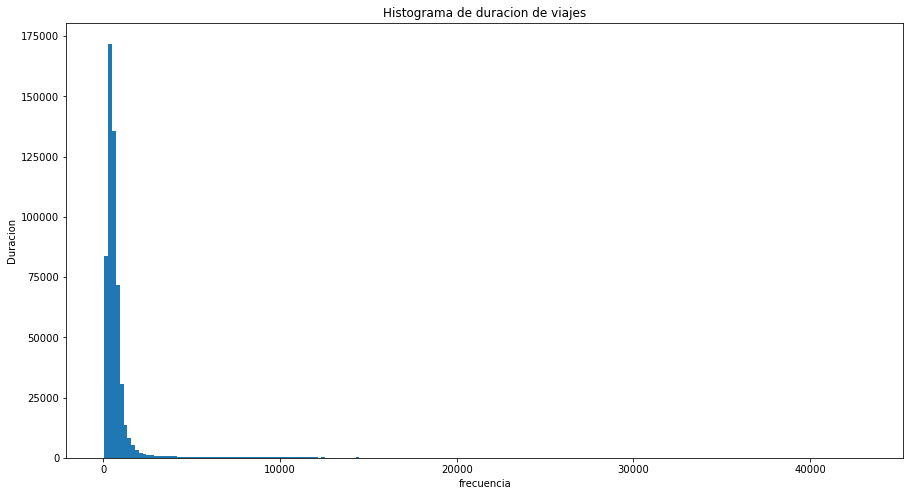

In [262]:
plt.figure(figsize=(15,8))
plt.title("Histograma de duracion de viajes")
plt.xlabel('frecuencia')
plt.ylabel('Duracion')
plt.hist(x=trips[trips['duration'] < trip_length]['duration'],bins=200)
plt.show()                       

In [263]:
trips = trips[trips['duration'] < trip_length]
print ("Total de viajes luego de remover outliers: " + str(trips.shape[0]))

Total de viajes luego de remover outliers: 548986


In [264]:
d = {'city': ['San Jose','Redwood City','Mountain View', 'Palo Alto', 'San Francisco'],\
         'zip_code':[95113,94063,94041,94301,94107]}
city_zip_codes = pd.DataFrame(data = d)

In [265]:
stations = pd.merge(stations, city_zip_codes, on='city', how='left')

In [266]:
# se agrega el zip_code de la ciudad de la start station a cada viaje
stations_to_join = stations.loc[:,['id','zip_code']]
stations_to_join.columns = ['start_station_id','city_zip_code']

trips = pd.merge(trips, stations_to_join, on='start_station_id', how='left')

In [267]:
weather.rename(columns={'zip_code':'city_zip_code'}, inplace=True)

In [268]:
weather.precipitation_inches = pd.to_numeric(weather.precipitation_inches, errors='coerse')
weather.precipitation_inches.fillna(0,inplace=True)

In [269]:
data = pd.merge(trips, weather, on=['date','city_zip_code'], how='inner')

In [270]:
# transformar cada date en segundos desde 29/04/1994
data.start_date = data.start_date.apply(lambda x: int((x - datetime.datetime(1994,4,29)).total_seconds()))

data.end_date = data.end_date.apply(lambda x: int((x - datetime.datetime(1994,4,29)).total_seconds()))

In [271]:
data.drop(labels=['id','start_station_name','end_station_name','date','zip_code','bike_id'], axis=1, inplace=True)
data.columns

Index(['duration', 'start_date', 'start_station_id', 'end_date',
       'end_station_id', 'subscription_type', 'city_zip_code',
       'max_temperature_f', 'mean_temperature_f', 'min_temperature_f',
       'max_dew_point_f', 'mean_dew_point_f', 'min_dew_point_f',
       'max_humidity', 'mean_humidity', 'min_humidity',
       'max_sea_level_pressure_inches', 'mean_sea_level_pressure_inches',
       'min_sea_level_pressure_inches', 'max_visibility_miles',
       'mean_visibility_miles', 'min_visibility_miles', 'max_wind_Speed_mph',
       'mean_wind_speed_mph', 'max_gust_speed_mph', 'precipitation_inches',
       'cloud_cover', 'events', 'wind_dir_degrees'],
      dtype='object')

#  Test Data Load

In [272]:
trip_test = pd.read_csv('data/trip_test.csv', parse_dates=['start_date','end_date'], infer_datetime_format=True)
trip_test.columns

Index(['id', 'start_date', 'start_station_name', 'start_station_id',
       'end_date', 'end_station_name', 'end_station_id', 'bike_id',
       'subscription_type', 'zip_code'],
      dtype='object')

In [273]:
# se agrega el zip_code de la ciudad de la start station a cada viaje del set de test
trip_test = pd.merge(trip_test, stations_to_join, on='start_station_id', how='left')

In [274]:
trip_test['date'] = pd.to_datetime(trip_test.start_date.dt.date)

trip_test = pd.merge(trip_test, weather, on=['date','city_zip_code'], how='inner')

In [275]:
# transformar cada date en segundos desde 29/04/1994
trip_test.start_date = trip_test.start_date.apply(lambda x: int((x - datetime.datetime(1994,4,29)).total_seconds()))
trip_test.end_date = trip_test.end_date.apply(lambda x: int((x - datetime.datetime(1994,4,29)).total_seconds()))

In [276]:
trip_test.drop(labels=['start_station_name','end_station_name','date','zip_code','bike_id'], axis=1, inplace=True)

In [277]:
trip_test.columns

Index(['id', 'start_date', 'start_station_id', 'end_date', 'end_station_id',
       'subscription_type', 'city_zip_code', 'max_temperature_f',
       'mean_temperature_f', 'min_temperature_f', 'max_dew_point_f',
       'mean_dew_point_f', 'min_dew_point_f', 'max_humidity', 'mean_humidity',
       'min_humidity', 'max_sea_level_pressure_inches',
       'mean_sea_level_pressure_inches', 'min_sea_level_pressure_inches',
       'max_visibility_miles', 'mean_visibility_miles', 'min_visibility_miles',
       'max_wind_Speed_mph', 'mean_wind_speed_mph', 'max_gust_speed_mph',
       'precipitation_inches', 'cloud_cover', 'events', 'wind_dir_degrees'],
      dtype='object')

# The Hashing Trick

### Train Set 

In [23]:
temp = []
column_labels = ['start_station_id','end_station_id','subscription_type','city_zip_code','events']

for row in data.loc[:,column_labels].iterrows():
    index, value = row
    for i in range(len(value)):
        value[i] = str(value[i])
    temp.append(value.tolist())

In [24]:
h = FeatureHasher(n_features=10, input_type='string')
f = h.transform(raw_X=temp)

In [25]:
print("Porcentaje de dispersidad: " + str((f.nnz/(f.shape[0] * f.shape[1]))*100) + " %")

Porcentaje de dispersidad: 41.19389201181815 %


In [26]:
data = pd.concat([data,pd.DataFrame(f.todense())],axis=1)
data.drop(labels=column_labels,axis=1,inplace=True)

In [27]:
# Verificamos que sean todos numericos
data.dtypes

duration                            int64
start_date                          int64
end_date                            int64
max_temperature_f                 float64
mean_temperature_f                float64
min_temperature_f                 float64
max_dew_point_f                   float64
mean_dew_point_f                  float64
min_dew_point_f                   float64
max_humidity                      float64
mean_humidity                     float64
min_humidity                      float64
max_sea_level_pressure_inches     float64
mean_sea_level_pressure_inches    float64
min_sea_level_pressure_inches     float64
max_visibility_miles              float64
mean_visibility_miles             float64
min_visibility_miles              float64
max_wind_Speed_mph                float64
mean_wind_speed_mph               float64
max_gust_speed_mph                float64
precipitation_inches              float64
cloud_cover                       float64
wind_dir_degrees                  

In [28]:
#data = data.dropna(how='any').reset_index(drop=True)

In [29]:
print ("Cantidad de muestras en train set: "+str(data.shape[0]))

Cantidad de muestras en train set: 548986


In [30]:
# Separamos y de x
target_values = data['duration']
data.drop(labels='duration', axis=1, inplace=True)

### Test Set

In [31]:
temp = []
column_labels = ['start_station_id','end_station_id','subscription_type','city_zip_code','events']

for row in trip_test.loc[:,column_labels].iterrows():
    index, value = row
    for i in range(len(value)):
        value[i] = str(value[i])
    temp.append(value.tolist())

In [32]:
h = FeatureHasher(n_features=10, input_type='string')
f = h.transform(raw_X=temp)

In [33]:
trip_test = pd.concat([trip_test,pd.DataFrame(f.todense())],axis=1)
trip_test.drop(labels=column_labels,axis=1,inplace=True)

In [34]:
trip_test.dtypes

id                                  int64
start_date                          int64
end_date                            int64
max_temperature_f                 float64
mean_temperature_f                float64
min_temperature_f                 float64
max_dew_point_f                   float64
mean_dew_point_f                  float64
min_dew_point_f                   float64
max_humidity                      float64
mean_humidity                     float64
min_humidity                      float64
max_sea_level_pressure_inches     float64
mean_sea_level_pressure_inches    float64
min_sea_level_pressure_inches     float64
max_visibility_miles              float64
mean_visibility_miles             float64
min_visibility_miles              float64
max_wind_Speed_mph                float64
mean_wind_speed_mph               float64
max_gust_speed_mph                float64
precipitation_inches              float64
cloud_cover                       float64
wind_dir_degrees                  

In [35]:
ids = trip_test['id']
trip_test.drop(labels=['id'], axis=1, inplace=True)

# Missing Values 

In [36]:
imp = preprocessing.Imputer(missing_values='NaN', strategy='most_frequent', axis=0)

start = time()

trip_test = imp.fit_transform(trip_test)

data = imp.fit_transform(data)

print ("Imputer took %.2f seconds",(time() - start))

Imputer took %.2f seconds 759.0693426132202


# Feature Engineering 

In [ ]:
clf = RandomForestClassifier(n_jobs=1)
clf.fit(data, target_values)

In [ ]:
importances = clf.feature_importances_
sorted_idx = np.argsort(importances)

In [ ]:
plt.barh(importances[sorted_idx], aling='center')
plt.yticks(data.columns[sorted_idx])
plt.xlabel('Relative Importace')
plt.ylabel('Variable Importance')
plt.show()

# Data Standarization

[scaler normaliza test y train set de la misma manera.](http://scikit-learn.org/stable/modules/preprocessing.html)

In [55]:
scaler = preprocessing.StandardScaler().fit(data)
scaler

StandardScaler(copy=True, with_mean=True, with_std=True)

In [56]:
data_stand = scaler.transform(data) # devuelve una matriz

In [57]:
trip_test_stand = scaler.transform(trip_test)

# Data Normalization

In [153]:
data_norm = (data - data.mean()) / (data.max() - data.min())
trip_test_norm = (trip_test - trip_test.mean()) / (trip_test.max() - trip_test.min())

# Dimension Reduction

## SVD

In [ ]:
u,s,v = np.linalg.svd(data,full_matrices=0)

## Energía de la matriz

In [ ]:
plt.figure(figsize=(8,8))
plt.xlabel("# valor singular")
plt.ylabel('Valor singular')
plt.title("Energia de la matriz")
plt.plot(s)
plt.show()

Vemos un codo en x = 5

# Aproximation error

In [ ]:
dim = 5
closeness = np.isclose(np.dot(np.dot(u[:,0:dim],np.diag(s)[0:dim,0:dim]),v[0:dim,:]),data,atol=0.1,rtol=0.1)
print (str((closeness.sum()/(closeness.shape[0]*closeness.shape[1])*100).round(2)) + " %")

# Truncated SVD

[...it can work with scipy.sparse matrices efficiently.](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html)

In [126]:
svd = TruncatedSVD(n_components=7, n_iter=7, random_state=42)
truncated_svd_aprox = svd.fit_transform(data)

# KNN 

In [127]:
reduced_data = truncated_svd_aprox

In [128]:
reduced_test = svd.fit_transform(trip_test)

In [ ]:
k_neighbors = np.array([40])
metrics = ['manhattan']
KNN_cv_scores = np.zeros(shape=(len(k_neighbors),len(metrics)))

for i,k in enumerate(k_neighbors):
    for j,metric in enumerate(metrics):
        
        knn = neighbors.KNeighborsRegressor(n_neighbors=k, metric=metric, weights = 'distance',n_jobs=-1)
        scores = cross_val_score(knn, reduced_data, target_values, cv=10, scoring='neg_mean_squared_error')
        KNN_cv_scores[i][j] = scores.mean()

In [ ]:
KNN_cv_scores.round(2)

knn con data normalization ,truncatedSVD, k = 20 --> array([[-5351858.19, -5360234.74]])

knn con data normalization ,SVD, k = 40 --> array([[-5253803.39, -5260328.7 ]])

knn con data standarization ,truncatedSVD (7 dim), k = 40 --> array([[-4737871.4 , -4733945.79]])

knn con data standarization ,truncatedSVD (10 dim), k = 40 --> array([[-4491750.19, -4483791.72]]) <-------------

knn con data standarization ,SVD, k = 40 --> array([[-5066280.98, -5021462.32]])

In [ ]:
KNN_cv_scores = np.array([[-6134361.15, -6079000.66],
					  [-5351858.19, -5360234.74],
					  [-5096953.65, -5095805.17],
					  [-4982807.73, -4969350.65],
					  [-4907901.23, -4890164.21],
					  [-4852908.1 , -4834866.28],
					  [-4817307.43, -4797754.1 ],
					  [-4790579.12, -4769114.32],
					  [-4767948.63, -4745718.41],
					  [-4751342.63, -4727356.28],
					  [-4739709.84, -4711076.88],
					  [-4726830.06, -4696665.8 ],
					  [-4715715.18, -4687716.97],
					  [-4706229.36, -4678451.76],
					  [-4697689.8 , -4670741.08],
					  [-4691308.05, -4665357.65],
					  [-4684562.35, -4659308.18],
					  [-4677509.1 , -4653394.41],
					  [-4672237.78, -4648805.1 ],
					  [-4667755.94, -4644264.32],
					  [-4662907.25, -4640719.22],
					  [-4658321.77, -4637249.78],
					  [-4654066.51, -4632933.27],
					  [-4650221.86, -4629486.34],
					  [-4646538.86, -4627016.1 ],
					  [-4642953.85, -4623886.01],
					  [-4639515.33, -4621242.79],
					  [-4636040.7 , -4618465.53],
					  [-4632803.81, -4615791.91],
					  [-4629935.04, -4613384.22],
					  [-4626602.03, -4611437.69],
					  [-4623721.83, -4608700.33],
					  [-4620566.86, -4606371.71],
					  [-4617386.36, -4604447.74],
					  [-4614419.37, -4603139.35],
					  [-4611734.2 , -4601562.83],
					  [-4609026.51, -4600178.79],
					  [-4607345.74, -4598160.78],
					  [-4605116.73, -4596688.19],
					  [-4603376.65, -4595194.93],
					  [-4601587.53, -4593121.06],
					  [-4600001.43, -4591552.04],
					  [-4598164.87, -4589910.62],
					  [-4596167.67, -4588453.26],
					  [-4594644.11, -4587628.87],
					  [-4593058.82, -4586432.97],
					  [-4591440.79, -4585359.34],
					  [-4590444.87, -4584486.15],
					  [-4588931.37, -4583458.19],
					  [-4587514.33, -4582651.52],
					  [-4585932.58, -4581528.13],
					  [-4584639.75, -4580836.93],
					  [-4583219.7 , -4579824.95],
					  [-4582349.66, -4579051.76],
					  [-4581703.28, -4578455.81],
					  [-4580664.6 , -4577890.98],
					  [-4579859.66, -4577140.71],
					  [-4578952.79, -4576545.1 ],
					  [-4578190.6 , -4576011.88],
					  [-4577508.68, -4575313.46],
					  [-4576812.1 , -4574810.81],
					  [-4576117.07, -4574246.79],
					  [-4575456.42, -4573528.77],
					  [-4575079.77, -4572995.22],
					  [-4574456.42, -4572555.19],
					  [-4573733.31, -4572173.41],
					  [-4572835.86, -4571679.54],
					  [-4571944.24, -4571347.05],
					  [-4571243.67, -4570827.76],
					  [-4570673.91, -4570314.32],
					  [-4570125.56, -4569726.02],
					  [-4569402.35, -4569275.26],
					  [-4568853.66, -4568817.24],
					  [-4568299.57, -4568358.15],
					  [-4567749.82, -4567980.21],
					  [-4567306.32, -4567479.81],
					  [-4566973.99, -4567107.05],
					  [-4566390.23, -4566979.09],
					  [-4566209.39, -4566688.21],
					  [-4565677.62, -4565677.62]])

KNN_cv_scores.max()

In [ ]:
plt.figure(figsize=(15,8))
plt.plot(KNN_cv_scores[:,1])
plt.title("Error de KNN")
plt.xlabel("k")
plt.ylabel("neg_mean_squared_error")
plt.show()

In [ ]:
# print (np.array(KNN_cv_scores).round(2)

# Estos prints están mal

print ("Best MSE: " + str(np.array(KNN_cv_scores).round(2).max()))
print ("Index of best MSE: " + str (np.array(KNN_cv_scores).round(2).argmax(axis=0)))
print ("Best k: " + str(k_neighbors[KNN_cv_scores.round(2).argmax(axis=1)[0]]) )
print ("Best metric: " + str(metrics[KNN_cv_scores.round(2).argmax(axis=1)[1]] ) )

# Bagging KNN 

In [ ]:
KNN = neighbors.KNeighborsRegressor(n_neighbors=40, metric='manhattan', weights = 'distance', n_jobs=-1)
bagging = BaggingRegressor(KNN, n_estimators=20, oob_score=True, n_jobs=-1, max_samples=1.0)

In [ ]:
start = time()
bagging.fit(reduced_data, target_values)
print("bagging with knn took %.2f seconds" % (time() - start))

In [ ]:
bagging.oob_score_

# Decision Tree Regressor

In [ ]:
possible_depth = np.array(range(10,1001,10))

In [ ]:
cv_scores = []

for current_depth in possible_depth:
    
    regr_1 = DecisionTreeRegressor(max_depth=current_depth)
    scores = cross_val_score(regr_1, data, target_values, cv=10, scoring='neg_mean_squared_error')
    DTR_cv_scores.append(scores.mean())

In [ ]:
print ("Best MSE: " + str(np.array(cv_scores).round(2).max()))
print ("Index of best MSE: " + str (np.array(cv_scores).round(2).argmax()))
print ("Best depth: " + str(possible_depth[np.array(cv_scores).round(2).argmax()]))

In [ ]:
plt.figure(figsize=(15,8))
plt.scatter(x=range(len(y_1)),y=y_1)
plt.show()

In [ ]:
plt.figure(figsize=(15,8))
plt.ylim(0,531240)
plt.scatter(x=range(len(Y_test)),y=Y_test)

# Random Forest Regressor

In [ ]:
parameters = {
                'max_depth':[5,6,7,8,9,10],
                'max_features':[1,2,3,5,7]
}

In [ ]:
regr_2 = RandomForestRegressor(n_estimators=50, oob_score=True)

In [ ]:
grid_search = GridSearchCV(regr_2, param_grid=parameters, n_jobs=-1, scoring='mean_squared_error')

In [ ]:
start = time()
grid_search.fit(data, target_values)

In [ ]:
print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))
print("Best score: ", grid_search.best_score_ , "Best parameters setting: ",grid_search.cv_results_['params'][grid_search.best_index_])

# Bayesian Ridge Regression

In [121]:
lambda1_values = [1.e-1,1.e-2,1.e-3,1.e-4]
lambda2_values = [1.e-7,1.e-8,1.e-9,1.e-10]
BRR_scores = np.zeros((len(lambda1_values),len(lambda2_values)))

for i,lambda1 in enumerate(lambda1_values):
    for j, lambda2 in enumerate(lambda2_values):
        
        bayesian_regression = BayesianRidge(lambda_1=lambda1, lambda_2=lambda2)
        scores = cross_val_score(bayesian_regression, data, target_values, cv=10, scoring='neg_mean_squared_error')
        BRR_scores[i][j] = scores.mean()

In [119]:
BRR_scores

array([[-671.48378628, -671.48378647, -671.48378656, -671.4837865 ],
       [-671.48378649, -671.48378631, -671.4837863 , -671.48378622],
       [-671.48378654, -671.48378628, -671.48378626, -671.48378601],
       [-671.48378628, -671.4837862 , -671.48378651, -671.48378612]])

In [120]:
bayesian_regression = BayesianRidge(lambda_1=1.e-9, lambda_2=1.e-10)
scores = cross_val_score(bayesian_regression, data, target_values, cv=10, scoring='neg_mean_squared_error')
scores.mean()

-671.48378600770479

n_iter = 400 --> -671.48378613510704

In [ ]:
BRR_scores

In [120]:
bayesian_bagging = BaggingRegressor(bayesian_regression, n_estimators=50, oob_score=True, n_jobs=-1, max_samples=0.5, max_features=1.0)

In [121]:
start = time()
bayesian_bagging.fit(data, target_values)
print("bagging with knn took %.2f seconds" % (time() - start))

bagging with knn took 52.81 seconds


In [122]:
bayesian_bagging.oob_score_

0.99985771964936176

# Linear Regression 

In [39]:
linear_regr = LinearRegression(fit_intercept=False, n_jobs=-1)
scores = cross_val_score(linear_regr, data, target_values, cv=10, scoring='neg_mean_squared_error')
scores.mean()

-671.50056893158012

# Elastic Net 

In [91]:
EN_regr = ElasticNet(alpha=0.5, l1_ratio=0.7, max_iter=2000)
scores = cross_val_score(EN_regr, data_stand, target_values, cv=10, scoring='neg_mean_squared_error')
scores.mean()

-4446976.4323270833

# Predictions 

In [37]:
trips = pd.read_csv('data/trip.csv')
original_values = trips.loc[trips.id.isin(ids), ['id','duration']]

### Bayesian Ridge Regression

In [38]:
bayesian_regression = BayesianRidge()

In [39]:
bayesian_regression.fit(data, target_values)

BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
       fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
       normalize=False, tol=0.001, verbose=False)

In [40]:
bayesian_pred = bayesian_regression.predict(trip_test)

In [41]:
BRR_results = pd.DataFrame(data=bayesian_pred, index=ids )
BRR_results.reset_index(inplace=True)
BRR_results.columns = ['id', 'duration']

df = pd.merge(BRR_results, original_values, on='id')

In [42]:
# MSE
((df['duration_x'] - df['duration_y']) ** 2).mean(axis=0)

603.2153832996873

In [43]:
BRR_results.to_csv('BRR_results.csv', index=False)

### Linear Regression

In [217]:
linear_regr = LinearRegression(fit_intercept=False,n_jobs=-1)

In [218]:
linear_regr.fit(data_norm, target_values)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=-1, normalize=False)

In [219]:
linear_pred = linear_regr.predict(trip_test_norm)

In [220]:
linear_results = pd.DataFrame(data=linear_pred, index=ids )
linear_results.reset_index(inplace=True)
linear_results.columns = ['id', 'duration']

df = pd.merge(linear_results, original_values, on='id')

In [221]:
# MSE
((df['duration_x'] - df['duration_y']) ** 2).mean(axis=0)

603.2261374993856

### Linear Regression Bagging 

In [195]:
linear_regr = LinearRegression(fit_intercept=False,n_jobs=-1)
linear_bagging = BaggingRegressor(linear_regr, n_estimators=50, max_samples=1.0, n_jobs=-1)

In [196]:
start = time()
linear_bagging.fit(data_norm, target_values)
print("fit took %.2f seconds", (time() - start))

fit took %.2f seconds 42.752437114715576


In [197]:
LRB_pred = linear_bagging.predict(trip_test_norm)

In [198]:
LRB_results = pd.DataFrame(data=LRB_pred, index=ids )
LRB_results.reset_index(inplace=True)
LRB_results.columns = ['id', 'duration']

df = pd.merge(LRB_results, original_values, on='id')

In [199]:
# MSE
((df['duration_x'] - df['duration_y']) ** 2).mean(axis=0)

603.2121270258898

### Bayesian Ridge Regression Bagging

In [148]:
bayesian_regression = BayesianRidge(lambda_1=1.e-9, lambda_2=1.e-10)
bayesian_bagging = BaggingRegressor(bayesian_regression, n_estimators=50, max_samples=1.0, n_jobs=-1)

In [149]:
start = time()
bayesian_bagging.fit(data, target_values)
print("fit took %.2f seconds", (time() - start))

fit took %.2f seconds 73.57496786117554


In [150]:
BRRB_pred = bayesian_bagging.predict(trip_test)

In [151]:
BRRB_results = pd.DataFrame(data=BRRB_pred, index=ids )
BRRB_results.reset_index(inplace=True)
BRRB_results.columns = ['id', 'duration']

df = pd.merge(BRRB_results, original_values, on='id')

In [152]:
# MSE
((df['duration_x'] - df['duration_y']) ** 2).mean(axis=0)

603.2381337039145

### KNN

In [129]:
KNN = neighbors.KNeighborsRegressor(n_neighbors=40, metric='manhattan', weights = 'distance', n_jobs=-1)

In [130]:
KNN.fit(reduced_data, target_values)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='manhattan',
          metric_params=None, n_jobs=-1, n_neighbors=40, p=2,
          weights='distance')

In [131]:
KNN_pred = KNN.predict(reduced_test)

In [132]:
KNN_results = pd.DataFrame(data=KNN_pred, index=ids )
KNN_results.reset_index(inplace=True)
KNN_results.columns = ['id', 'duration']

df = pd.merge(KNN_results, original_values, on='id')

In [133]:
# MSE
((df['duration_x'] - df['duration_y']) ** 2).mean(axis=0)

42040308.24206249

### Random Forest Regressor 

In [ ]:
RFR = RandomForestRegressor(n_estimators=50, max_features=7, max_depth=8)

In [ ]:
RFR.fit(data, target_values)

In [ ]:
RFR_pred = RFR.predict(trip_test)

In [ ]:
RFR_results = pd.DataFrame(data=RFR_pred, index=ids )
RFR_results.reset_index(inplace=True)
RFR_results.columns = ['id', 'duration']

df = pd.merge(RFR_results, original_values, on='id')

In [ ]:
# MSE
((df['duration_x'] - df['duration_y']) ** 2).mean(axis=0)

### Averaging

In [226]:
avg_results = pd.merge(LRB_results, BRRB_results, on='id')

In [227]:
avg_results['duration'] = pd.DataFrame(data=avg_results.loc[:, ['duration_x','duration_y']].mean(axis=1))
avg_results.drop(labels=['duration_x','duration_y'], axis=1, inplace=True)

In [203]:
df = pd.merge(avg_results, original_values, on='id')

In [204]:
# MSE
((df['duration_x'] - df['duration_y']) ** 2).mean(axis=0)

603.2239918213355

# Algorithm 

In [282]:
# Python 2
from __future__ import division

# Dataframe
import pandas as pd
import numpy as np

# Time measurement
import datetime
from time import time

# The Hashing Trick
from sklearn import preprocessing
from sklearn.feature_extraction import FeatureHasher

# Dimension Reduction
from sklearn.decomposition import TruncatedSVD

# ML
from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import LinearRegression


def preprocess_data(stations, weather, train_trips, test_trips):

    stations = pd.merge(stations, cities, on='city', how='left').loc[:, ['id', 'zip_code']]
    stations.columns = ['start_station_id', 'city_zip_code']

    train_trips = pd.merge(train_trips, stations, on='start_station_id', how='left')
    train_trips['date'] = pd.to_datetime(train_trips.start_date.dt.date)
    train_trips.start_date = train_trips.start_date.apply(lambda x: int((x - datetime.datetime(1994, 4, 29)).total_seconds()))
    train_trips.end_date = train_trips.end_date.apply(lambda x: int((x - datetime.datetime(1994, 4, 29)).total_seconds()))

    test_trips = pd.merge(test_trips, stations, on='start_station_id', how='left')
    test_trips['date'] = pd.to_datetime(test_trips.start_date.dt.date)
    test_trips.start_date = test_trips.start_date.apply(lambda x: int((x - datetime.datetime(1994, 4, 29)).total_seconds()))
    test_trips.end_date = test_trips.end_date.apply(lambda x: int((x - datetime.datetime(1994, 4, 29)).total_seconds()))

    weather.rename(columns={'zip_code': 'city_zip_code'}, inplace=True)
    weather.precipitation_inches = pd.to_numeric(weather.precipitation_inches, errors='coerse')
    weather.precipitation_inches.fillna(0, inplace=True)

    train_data = pd.merge(train_trips, weather, on=['date', 'city_zip_code'], how='inner')
    train_data.drop(labels=['id', 'start_station_name', 'end_station_name', 'date', 'zip_code', 'bike_id'], axis=1, inplace=True)

    test_data = pd.merge(test_trips, weather, on=['date', 'city_zip_code'], how='inner')
    test_data.drop(labels=['start_station_name', 'end_station_name', 'date', 'zip_code', 'bike_id'], axis=1, inplace=True)

    return train_data, test_data


def the_Hashing_Trick(data, column_labels):

    temp = []

    for row in data.loc[:, column_labels].iterrows():
        index, value = row
        for i in range(len(value)):
            value[i] = str(value[i])
        temp.append(value.tolist())

    h = FeatureHasher(n_features=10, input_type='string')
    f = h.transform(raw_X=temp)

    data = pd.concat([data, pd.DataFrame(f.todense())], axis=1)
    data.drop(labels=column_labels, axis=1, inplace=True)

    return data


def data_normalization(train_data, test_data):

    data = (train_data - train_data.mean()) / (train_data.max() - train_data.min())

    t_data = (test_data - test_data.mean()) / (test_data.max() - test_data.min())
    
    return data, t_data


def reduce_dimentions_to(data, n_dimensions = 5):

    svd = TruncatedSVD(n_components=n_dimensions, n_iter=7, random_state=42)

    return svd.fit_transform(data)


def impute_nan(data, strategy):

    return preprocessing.Imputer(missing_values='NaN', strategy=strategy, axis=0).fit_transform(data)


def train_bayesian_model(x, y):

    bayesian_regression = BayesianRidge(lambda_1=1.e-9, lambda_2=1.e-10)

    return BaggingRegressor(bayesian_regression, n_estimators=20, max_samples=0.5, n_jobs=-1).fit(x, y)


def train_linear_model(x, y):

    linear_regression = LinearRegression(fit_intercept=False,n_jobs=-1)

    return BaggingRegressor(linear_regression, n_estimators=20, max_samples=1.0, n_jobs=-1).fit(x, y)


#input
stations = pd.read_csv('data/station.csv')
weather = pd.read_csv('data/weather.csv', parse_dates=['date'], infer_datetime_format=True)
cities = pd.read_csv('data/cities.csv')

trip_train = pd.read_csv('data/trip_train.csv',  parse_dates=['start_date', 'end_date'], infer_datetime_format=True,low_memory=False)
trip_test = pd.read_csv('data/trip_test.csv',  parse_dates=['start_date', 'end_date'], infer_datetime_format=True,low_memory=False)

# Pre-processing
train_set, test_set = preprocess_data(stations, weather, trip_train, trip_test)

# Feature Hashing
column_labels = ['start_station_id','end_station_id','subscription_type','city_zip_code','events']
train_set = the_Hashing_Trick(train_set, column_labels)
test_set = the_Hashing_Trick(test_set, column_labels)

target_values = train_set['duration']
train_set.drop(labels='duration', axis=1, inplace=True)

ids = test_set['id']
test_set.drop(labels=['id'], axis=1, inplace=True)

# NaN Imputation
train_set = impute_nan(train_set, 'most_frequent')
test_set = impute_nan(test_set, 'most_frequent')

# Data Normalization
train_set_normalized, test_set_normalized = data_normalization(train_set, test_set)

# Training
bayesian_regressor = train_bayesian_model(train_set, target_values)
linear_regressor = train_linear_model(train_set_normalized, target_values)

# Predictions
bayesian_pred = bayesian_regressor.predict(test_set)
bayesian_results = pd.DataFrame(data=bayesian_pred, index=ids)
bayesian_results.reset_index(inplace=True)
bayesian_results.columns = ['id', 'duration']

linear_pred = linear_regressor.predict(test_set_normalized)
linear_results = pd.DataFrame(data=linear_pred, index=ids)
linear_results.reset_index(inplace=True)
linear_results.columns = ['id', 'duration']

results = pd.merge(linear_results, bayesian_results, on='id')
results['duration'] = pd.DataFrame(data=results.loc[:, ['duration_x','duration_y']].mean(axis=1))
results.drop(labels=['duration_x','duration_y'], axis=1, inplace=True)

results.to_csv('results.csv', index=False)